In [1]:
import os
import graph_tool.all as gt
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Organizing Data

In [ ]:
# Paths
graph_files_path = "/Users/leahbiram/Desktop/vasculature_data/"  # Directory containing .gt files
prediction_file_path = "/Users/leahbiram/Desktop/vasculature_data/node_level_predictions2.csv"  # CSV with prediction data

# Load prediction data
prediction_df = pd.read_csv(prediction_file_path)

# Create an empty list to store the final data
node_data = []

# Loop through each graph file
for filename in os.listdir(graph_files_path):
    if filename.endswith(".gt"):
        graph_name = filename.split("_")[0]
        print(f"Processing graph: {graph_name}")

        # Load the graph
        graph = gt.load_graph(os.path.join(graph_files_path, filename))

        # Extract node-level features from the graph
        graph_features = pd.DataFrame({
            name: [prop[v] for v in graph.vertices()]
            for name, prop in graph.vp.items()
        })
        graph_features["node_index"] = range(graph.num_vertices())  # Add node index

        # Add degree feature to the graph features
        graph_features["degree"] = graph.get_total_degrees(graph.get_vertices())  # Degree of each node

        # Filter the prediction data for the current graph
        graph_prediction = prediction_df[prediction_df["sample"] == graph_name]

        # Ensure both dataframes are aligned on the same nodes
        if len(graph_prediction) != len(graph_features):
            raise ValueError(f"Mismatch in node count for graph {graph_name}.")

        # Merge graph features and prediction data
        merged_data = pd.concat([graph_features, graph_prediction.reset_index(drop=True)], axis=1)
        merged_data["graph_name"] = graph_name  # Add graph name as a column

        # Append to the node_data list
        node_data.append(merged_data)

        del graph, graph_features, merged_data
        gc.collect()

# Combine all graph data into a single dataframe
final_node_df = pd.concat(node_data, ignore_index=True)

# Save the final dataframe for further use
final_node_df.to_csv("node_features_with_prediction.csv", index=False)
print("Final dataframe saved!")


In [2]:
final_node_df = pd.read_csv("node_features_with_prediction.csv")

In [5]:
final_node_df["graph_base"] = final_node_df["graph_name"].str.extract(r"([A-Za-z]+\d+)")[0]
sampled_df = final_node_df.groupby("graph_base").apply(
    lambda x: x.sample(n=min(10000, len(x)), random_state=42)
).reset_index(drop=True)

# Save the sampled DataFrame to a CSV file
sampled_df.to_csv('sampled_data.csv', index=False)

# Basic Analysis - graph sizes

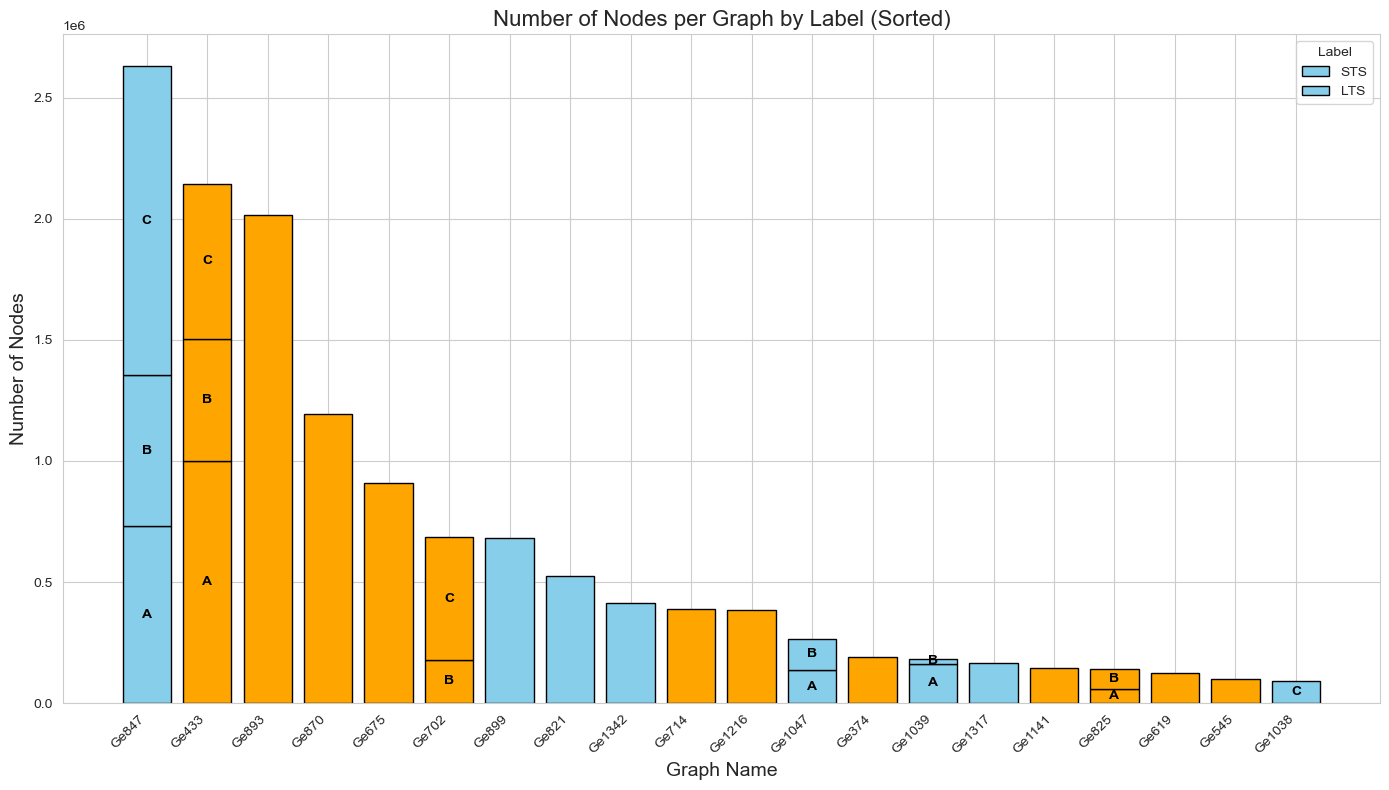

In [7]:
# Remove suffix from `graph_name` (e.g., Gr124A -> Gr124, Gr124B -> Gr124)
final_node_df["graph_base"] = final_node_df["graph_name"].str.extract(r"([A-Za-z]+\d+)")[0]

# Count the number of nodes per graph_base, label, and graph_name (individual splits)
node_counts = final_node_df.groupby(["graph_base", "label", "graph_name"]).size().reset_index(name="count")

# Calculate total size and optional label-specific metrics for sorting
graph_totals = (
    node_counts.groupby("graph_base")["count"].sum().reset_index(name="total_size")
)
label_0_sizes = (
    node_counts[node_counts["label"] == 0]
    .groupby("graph_base")["count"].sum()
    .reset_index(name="label_0_size")
)
label_1_sizes = (
    node_counts[node_counts["label"] == 1]
    .groupby("graph_base")["count"].sum()
    .reset_index(name="label_1_size")
)

# Combine for sorting
sorting_df = graph_totals.merge(label_0_sizes, on="graph_base", how="left").merge(
    label_1_sizes, on="graph_base", how="left"
)
sorting_df = sorting_df.fillna(0)  # Fill missing values (if any) with 0

# Choose a sorting method (by total size, label 0 size, or label 1 size)
sorting_criteria = sorting_df.sort_values(
    by=["total_size", "label_0_size", "label_1_size"], ascending=False
)

# Apply the sorting order to the node_counts dataframe
node_counts["graph_base"] = pd.Categorical(
    node_counts["graph_base"], categories=sorting_criteria["graph_base"], ordered=True
)
node_counts = node_counts.sort_values(by=["graph_base", "label", "graph_name"])

# Visualization
fig, ax = plt.subplots(figsize=(14, 8))
bar_width = 0.8

# Unique graph bases in the sorted order
unique_graph_bases = sorting_criteria["graph_base"]

x_positions = range(len(unique_graph_bases))

for i, graph_base in enumerate(unique_graph_bases):
    current_bottom = 0  # Start stacking from the bottom
    base_data = node_counts[node_counts["graph_base"] == graph_base]

    for _, row in base_data.iterrows():
        # Stack bar segment for the current split
        ax.bar(
            x_positions[i],
            row["count"],
            width=bar_width,
            bottom=current_bottom,
            color="skyblue" if row["label"] == 0 else "orange",
            edgecolor="black",
        )

        # Extract the split suffix (e.g., A, B, C)
        split_suffix = row["graph_name"][-1]

        # Check if the suffix is a letter
        if split_suffix.isalpha():
            # Add the split name in the middle of the stack
            ax.text(
                x_positions[i],
                current_bottom + row["count"] / 2,
                split_suffix,
                ha="center",
                va="center",
                color="black",
                fontsize=10,
                fontweight="bold",
            )

        current_bottom += row["count"]  # Update the bottom for the next stack

# Add graph_base as x-tick labels
ax.set_xticks(x_positions)
ax.set_xticklabels(unique_graph_bases, rotation=45, ha="right")

# Add titles and labels
ax.set_title("Number of Nodes per Graph by Label (Sorted)", fontsize=16)
ax.set_xlabel("Graph Name", fontsize=14)
ax.set_ylabel("Number of Nodes", fontsize=14)
ax.legend(title="Label", labels=["STS", "LTS"])
plt.tight_layout()
plt.show()


/var/folders/m0/70ds_67921g7_0y19wkz3yrc0000gn/T/ipykernel_53547/1499945007.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_by_label = final_node_df.groupby(["pred_bin", "label"]).size().unstack(fill_value=0)


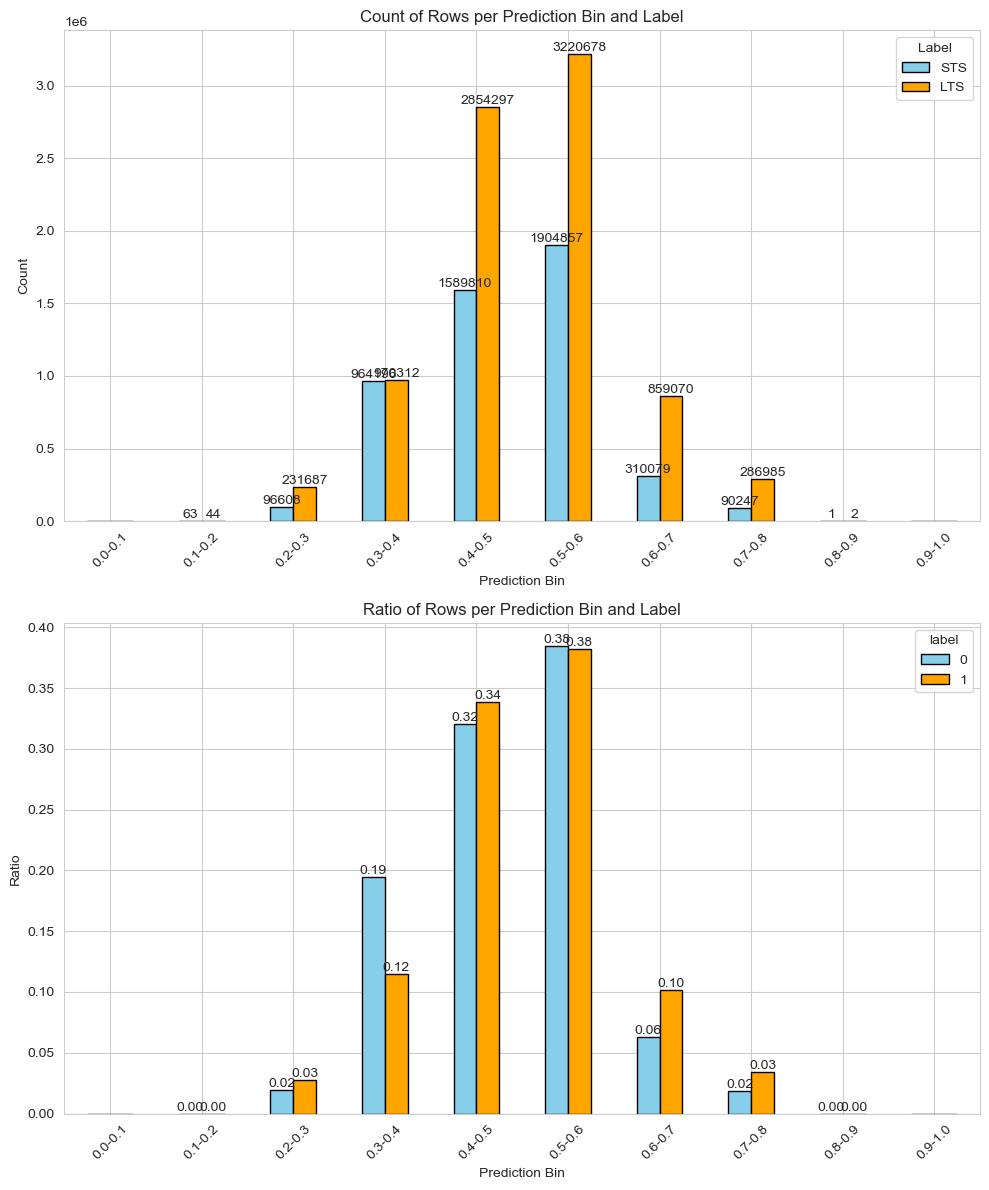

In [6]:
# Define bins for "pred"
bins = np.arange(0, 1.1, 0.1)  # Bins from 0 to 1 with a step of 0.1
bin_labels = [f"{round(bins[i], 1)}-{round(bins[i+1], 1)}" for i in range(len(bins) - 1)]

# Add a "pred_bin" column based on the bins
final_node_df["pred_bin"] = pd.cut(final_node_df["pred"], bins=bins, labels=bin_labels, include_lowest=True)

# Group by both "pred_bin" and "label" to get the counts for each combination of "pred_bin" and "label"
counts_by_label = final_node_df.groupby(["pred_bin", "label"]).size().unstack(fill_value=0)

# Calculate class totals for normalization
class_totals = final_node_df["label"].value_counts()  # Total number of points per class

# Calculate counts and normalize to ratios
ratios_by_label = counts_by_label.div(class_totals, axis=1)  # Divide counts by class totals

# Visualization: Counts
fig, axes = plt.subplots(2, 1, figsize=(10, 12))  # Two subplots for counts and ratios

# Plot the original counts per bin
counts_by_label.plot(
    kind="bar", stacked=False, ax=axes[0], color=["skyblue", "orange"], edgecolor="black"
)
axes[0].set_title("Count of Rows per Prediction Bin and Label")
axes[0].set_xlabel("Prediction Bin")
axes[0].set_ylabel("Count")
axes[0].set_xticks(range(len(bin_labels)))
axes[0].set_xticklabels(bin_labels, rotation=45)
axes[0].legend(title="Label", labels=["STS", "LTS"])

# Annotate counts above each bar
for container in axes[0].containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:  # Only annotate bars with positive height
            axes[0].text(bar.get_x() + bar.get_width() / 2, height, int(height),
                         ha='center', va='bottom', fontsize=10)

# Plot the normalized ratios per bin
ratios_by_label.plot(
    kind="bar", stacked=False, ax=axes[1], color=["skyblue", "orange"], edgecolor="black"
)
axes[1].set_title("Ratio of Rows per Prediction Bin and Label")
axes[1].set_xlabel("Prediction Bin")
axes[1].set_ylabel("Ratio")
axes[1].set_xticks(range(len(bin_labels)))
axes[1].set_xticklabels(bin_labels, rotation=45)
axes[0].legend(title="Label", labels=["STS", "LTS"])

# Annotate ratios above each bar
for container in axes[1].containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:  # Only annotate bars with positive height
            axes[1].text(bar.get_x() + bar.get_width() / 2, height, f"{height:.2f}",
                         ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


# Basic Analysis - Features Distribution

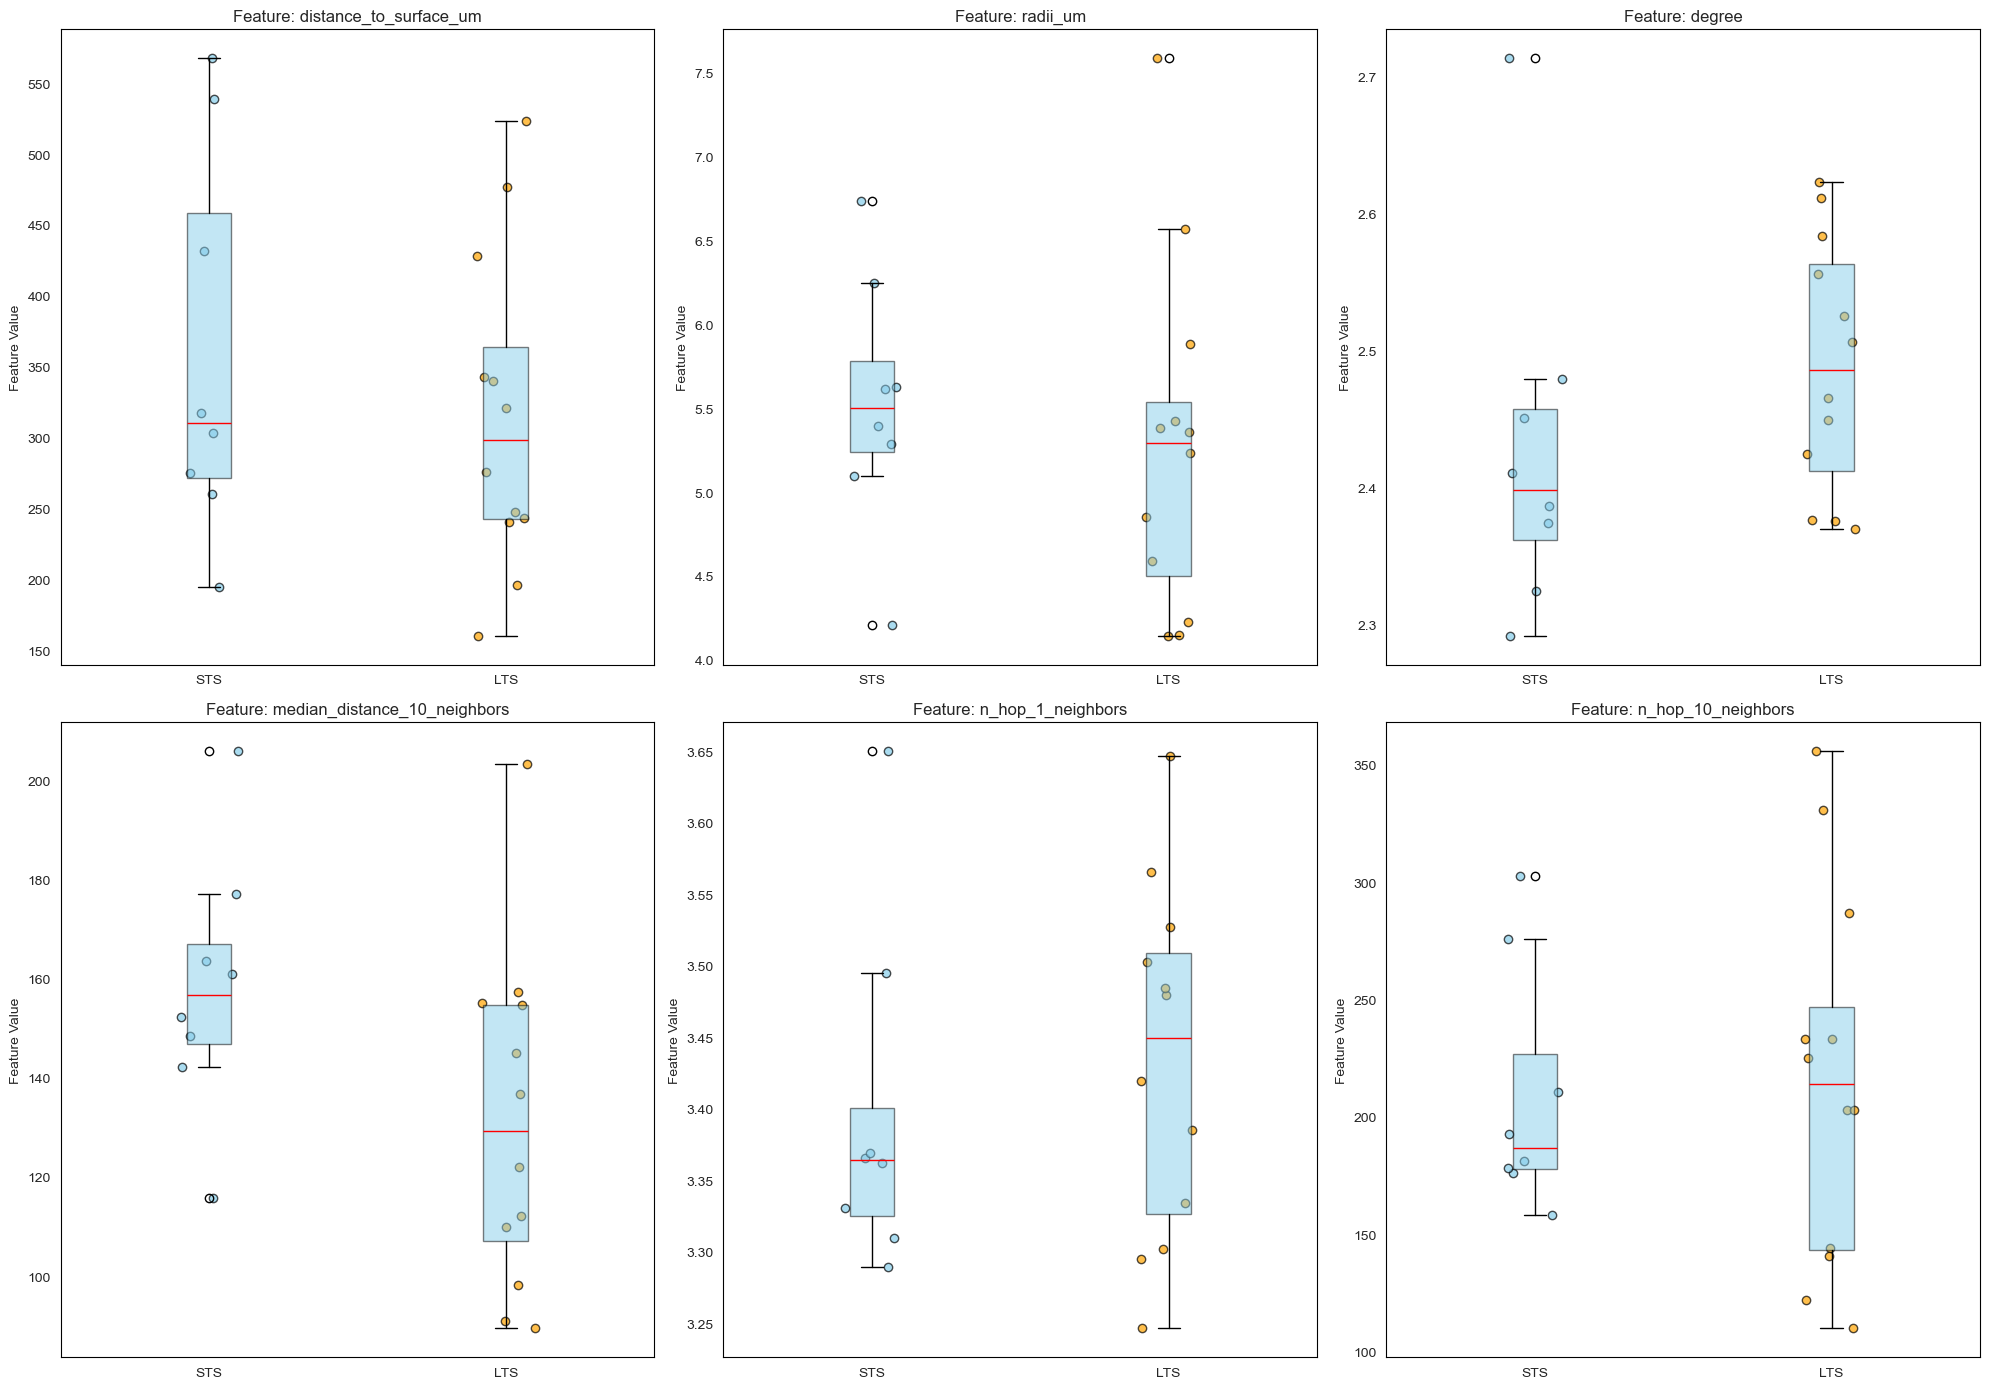

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming `final_node_df` is your original dataframe

# Remove suffix from `graph_name` (e.g., Gr124A -> Gr124, Gr124B -> Gr124)
final_node_df["graph_base"] = final_node_df["graph_name"].str.extract(r"([A-Za-z]+\d+)")[0]

# Define the features to be analyzed
feature_columns = [
    "distance_to_surface_um",
    "radii_um",
    "degree",
    "median_distance_10_neighbors",
    "n_hop_1_neighbors",
    "n_hop_10_neighbors"
]

# Colors for labels 0 and 1
colors = ["skyblue", "orange"]

# Aggregate the data by `graph_base` and `label`, using mean for each feature
aggregated_df = (
    final_node_df.groupby(["graph_base", "label"])[feature_columns]
    .mean()
    .reset_index()
)

aggregated_df.to_csv("sample_features_with_prediction.csv", index=False)

# Number of features to visualize
n_features = len(feature_columns)
n_cols = 3  # Number of columns for subplots
n_rows = (n_features + n_cols - 1) // n_cols  # Calculate rows required

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 7 * n_rows))

for idx, feature in enumerate(feature_columns):
    row, col = divmod(idx, n_cols)
    ax = axes[row, col] if n_rows > 1 else axes[col]

    # Separate data for labels 0 and 1
    label_0_data = aggregated_df[aggregated_df["label"] == 0][feature]
    label_1_data = aggregated_df[aggregated_df["label"] == 1][feature]

    # Create boxplots
    ax.boxplot(
        [label_0_data, label_1_data],
        vert=True,
        patch_artist=True,
        labels=["STS", "LTS"],
        boxprops=dict(color="black", facecolor=colors[0], alpha=0.5),
        whiskerprops=dict(color="black"),
        capprops=dict(color="black"),
        medianprops=dict(color="red"),
    )

    # Add scatter points with jitter at correct x positions
    jitter_strength = 0.1
    ax.scatter(np.full(len(label_0_data), 1) + np.random.uniform(-jitter_strength, jitter_strength, len(label_0_data)),
               label_0_data, color=colors[0], alpha=0.7, edgecolor="black")
    ax.scatter(np.full(len(label_1_data), 2) + np.random.uniform(-jitter_strength, jitter_strength, len(label_1_data)),
               label_1_data, color=colors[1], alpha=0.7, edgecolor="black")

    ax.set_title(f"Feature: {feature}")
    ax.set_ylabel("Feature Value")
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_color("black")

# Remove unused subplots
for idx in range(n_features, n_rows * n_cols):
    fig.delaxes(axes.flatten()[idx])
plt.tight_layout()
plt.show()


In [3]:
cd3_df.head()

,sample,node_index,cd3_count_10,cd3_intensity_sum_10,cd3_intensity_mean_10,cd3_volume_mean_10,cd3_density_10,cd3_count_20,cd3_intensity_sum_20,cd3_intensity_mean_20,cd3_volume_mean_20,cd3_density_20,cd3_count_50,cd3_intensity_sum_50,cd3_intensity_mean_50,cd3_volume_mean_50,cd3_density_50
0,Ge1047B,0,1.0,2775.673096,2775.673096,315.0,0.000239,6.0,19653.343750,3275.557373,312.166667,0.000179,31.0,92934.140625,2997.875488,313.870968,0.000059
1,Ge1047B,1,1.0,920.472351,920.472351,470.0,0.000239,3.0,3645.843262,1215.281128,351.666667,0.000090,36.0,49268.714844,1368.575439,362.388889,0.000069
2,Ge1047B,2,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,22.0,14306.014648,650.273376,386.136364,0.000042
3,Ge1047B,3,0.0,0.000000,0.000000,0.0,0.000000,2.0,8121.277344,4060.638672,380.500000,0.000060,20.0,37113.968750,1855.698486,354.300000,0.000038
4,Ge1047B,4,1.0,3255.489502,3255.489502,237.0,0.000239,2.0,6760.409180,3380.204590,274.000000,0.000060,26.0,52852.031250,2032.770386,349.692308,0.000050


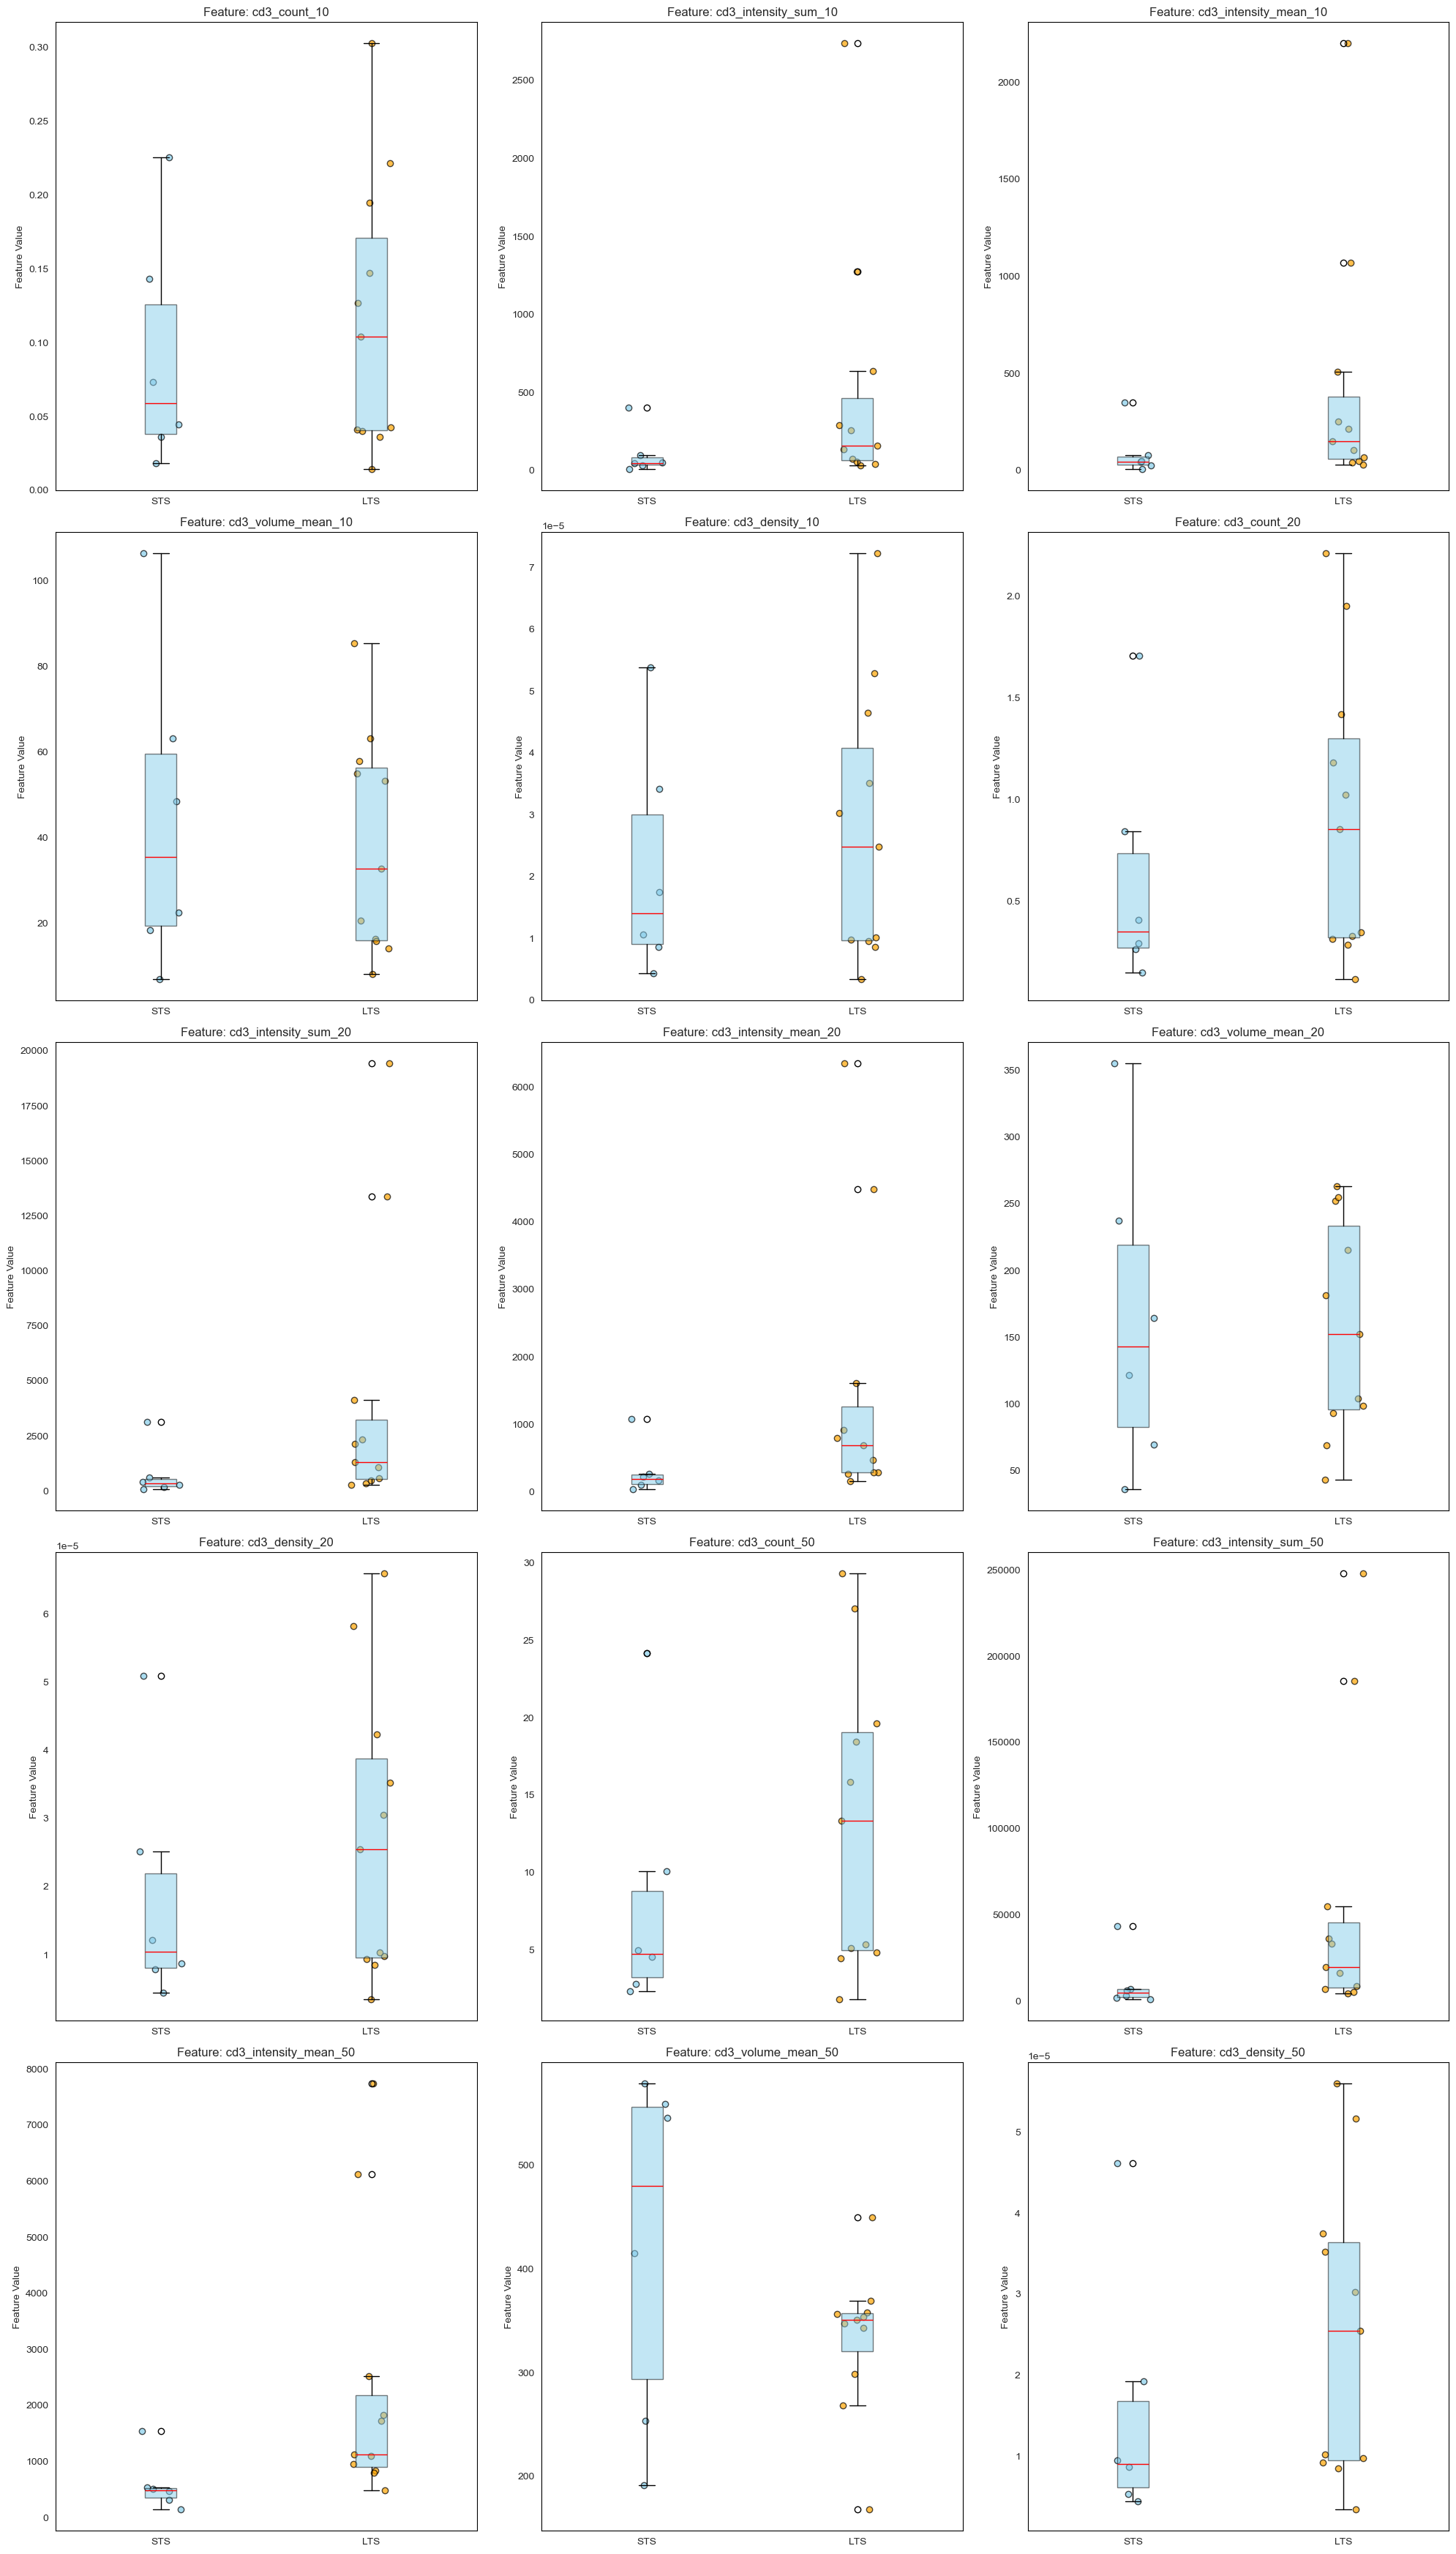

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load CD3 features
cd3_df = pd.read_csv("../../cd3_features_combined_with_labels.csv")

# Load sample label mapping (adjust path as needed)
#labels_df = pd.read_csv("../../GBM_data/GBM_data_labels.csv")  # Should have columns: sample,label

# Merge label into CD3 dataframe
#cd3_df = cd3_df.merge(labels_df, on="sample", how="left")

# Choose CD3 features to analyze
cd3_features = [col for col in cd3_df.columns if col.startswith("cd3_")]

# Aggregate by sample and label
#agg_df = cd3_df.groupby(["sample", "label"])[cd3_features].mean().reset_index()

# Assuming `final_node_df` is your original dataframe

# Remove suffix from `graph_name` (e.g., Gr124A -> Gr124, Gr124B -> Gr124)
cd3_df["graph_base"] = cd3_df["sample"].str.extract(r"([A-Za-z]+\d+)")[0]

# Define the features to be analyzed
feature_columns = [col for col in cd3_df.columns if col.startswith("cd3_")]

# Colors for labels 0 and 1
colors = ["skyblue", "orange"]

# Aggregate the data by `graph_base` and `label`, using mean for each feature
aggregated_df = (
    cd3_df.groupby(["graph_base", "label"])[feature_columns]
    .mean()
    .reset_index()
)

# Number of features to visualize
n_features = len(feature_columns)
n_cols = 3  # Number of columns for subplots
n_rows = (n_features + n_cols - 1) // n_cols  # Calculate rows required

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 7 * n_rows))

for idx, feature in enumerate(feature_columns):
    row, col = divmod(idx, n_cols)
    ax = axes[row, col] if n_rows > 1 else axes[col]

    # Separate data for labels 0 and 1
    label_0_data = aggregated_df[aggregated_df["label"] == "STS"][feature]
    label_1_data = aggregated_df[aggregated_df["label"] == "LTS"][feature]

    # Create boxplots
    ax.boxplot(
        [label_0_data, label_1_data],
        vert=True,
        patch_artist=True,
        labels=["STS", "LTS"],
        boxprops=dict(color="black", facecolor=colors[0], alpha=0.5),
        whiskerprops=dict(color="black"),
        capprops=dict(color="black"),
        medianprops=dict(color="red"),
    )

    # Add scatter points with jitter at correct x positions
    jitter_strength = 0.1
    ax.scatter(np.full(len(label_0_data), 1) + np.random.uniform(-jitter_strength, jitter_strength, len(label_0_data)),
               label_0_data, color=colors[0], alpha=0.7, edgecolor="black")
    ax.scatter(np.full(len(label_1_data), 2) + np.random.uniform(-jitter_strength, jitter_strength, len(label_1_data)),
               label_1_data, color=colors[1], alpha=0.7, edgecolor="black")

    ax.set_title(f"Feature: {feature}")
    ax.set_ylabel("Feature Value")
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_color("black")

# Remove unused subplots
for idx in range(n_features, n_rows * n_cols):
    fig.delaxes(axes.flatten()[idx])
plt.tight_layout()
plt.show()


In [18]:
label


'STS'

/Users/leahbiram/opt/anaconda3/envs/napari-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/leahbiram/opt/anaconda3/envs/napari-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/leahbiram/opt/anaconda3/envs/napari-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/leahbiram/opt/anaconda3/envs/napari-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: F

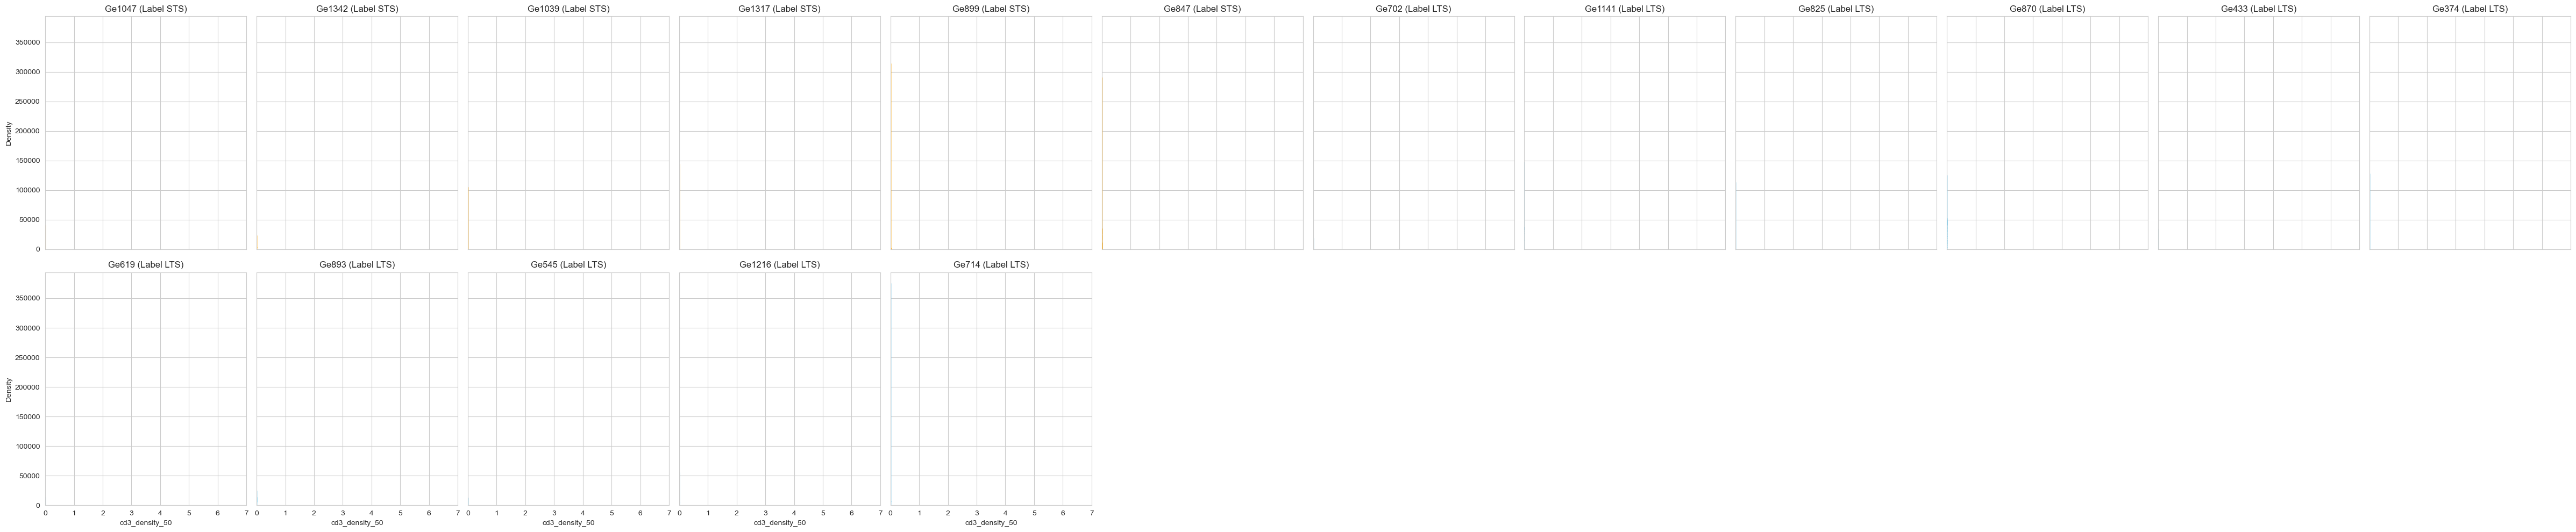

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming `final_node_df` is your original dataframe

# Remove suffix from `graph_name` (e.g., Gr124A -> Gr124, Gr124B -> Gr124)
#final_node_df["graph_base"] = final_node_df["sample"].str.extract(r"([A-Za-z]+\d+)")[0]
final_node_df["graph_base"] = final_node_df["graph_name"].str.extract(r"([A-Za-z]+\d+)")[0]

# Feature to plot (change this to any feature)
feature_to_plot = degree

# Define max figures per row
max_cols = 12

# Get unique samples
samples = final_node_df["graph_base"].unique()

# Colors for labels
palette = {0: "skyblue", 1: "orange"}

# Separate samples by label
label_0_samples = final_node_df[final_node_df["label"] == 0]["graph_base"].unique()
label_1_samples = final_node_df[final_node_df["label"] == 1]["graph_base"].unique()

# Organize samples into rows with at most `max_cols` per row
sample_groups = [label_1_samples, label_0_samples]

# Calculate number of rows needed
n_rows = sum((len(group) + max_cols - 1) // max_cols for group in sample_groups)

# Create subplots
fig, axes = plt.subplots(n_rows, max_cols, figsize=(max_cols * 4, 5 * n_rows), sharex=True, sharey=True)
axes = axes.flatten()

plot_idx = 0  # Keep track of subplot index

for label, sample_list in zip([0,1], sample_groups):
    for sample in sample_list:
        ax = axes[plot_idx]
        sample_data = final_node_df[(final_node_df["graph_base"] == sample) & (final_node_df["label"] == label)]

        # Check if there are enough points for KDE
        if len(sample_data) > 1:
            sns.kdeplot(
                data=sample_data,
                x=feature_to_plot,
                fill=True,
                color=palette[label],
                alpha=0.5,
                ax=ax,
            )
        else:
            # If few points, plot them as dots
            ax.scatter(sample_data[feature_to_plot], np.zeros(len(sample_data)), color=palette[label])

        ax.set_title(f"{sample} (Label {label})")
        ax.set_xlabel(feature_to_plot)
        ax.set_ylabel("Density")

        # Limit the x-axis to 10, any value above will be considered as an outlier
        ax.set_xlim(0, 7)

        plot_idx += 1  # Move to the next subplot

# Remove any unused subplots
for idx in range(plot_idx, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


# Feature Distributions Across Prediction Score

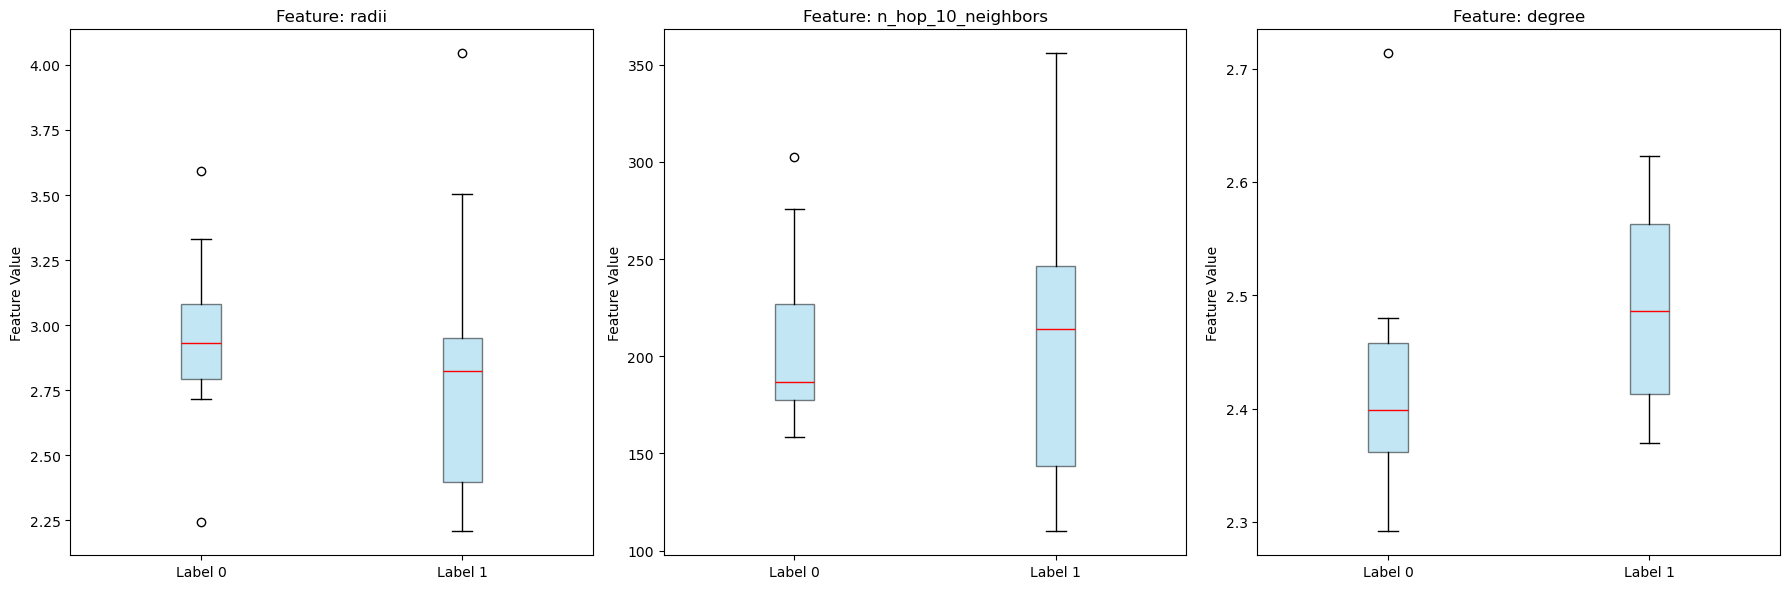

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `final_node_df` is available with the required structure
# Remove suffix from `graph_name` (e.g., Gr124A -> Gr124, Gr124B -> Gr124)
final_node_df["graph_base"] = final_node_df["graph_name"].str.extract(r"([A-Za-z]+\d+)")[0]

# Define the features to be analyzed
selected_features = ["radii", "n_hop_10_neighbors", "degree"]
colors = ["skyblue", "orange"]

# Aggregate the data by `graph_base` and `label`, using mean for each feature
aggregated_df = (
    final_node_df.groupby(["graph_base", "label"])[selected_features]
    .mean()
    .reset_index()
)

# Number of features to visualize
n_features = len(selected_features)

fig, axes = plt.subplots(1, n_features, figsize=(6 * n_features, 6))

for idx, feature in enumerate(selected_features):
    ax = axes[idx]

    # Separate data for labels 0 and 1
    label_0_data = aggregated_df[aggregated_df["label"] == 0][feature]
    label_1_data = aggregated_df[aggregated_df["label"] == 1][feature]

    # Create boxplots
    ax.boxplot(
        [label_0_data, label_1_data],
        vert=True,
        patch_artist=True,
        labels=["Label 0", "Label 1"],
        boxprops=dict(color="black", facecolor=colors[0], alpha=0.5),
        whiskerprops=dict(color="black"),
        capprops=dict(color="black"),
        medianprops=dict(color="red"),
    )

    ax.set_title(f"Feature: {feature}")
    ax.set_ylabel("Feature Value")

plt.tight_layout()
plt.show()
